In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gtsam
import gtsam.utils.plot
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
path_to_images = '/Users/Documents/Northeastern/EECE 7150/HW4/buddha_images'
images = os.listdir(path_to_images)
images.sort()
grey_imgs = []
imgs = []
bgr_imgs = []

for image in images:
    path_to_image = os.path.join(path_to_images, image)
    img = cv2.imread(path_to_image)
    bgr_imgs.append(img)

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    grey_imgs.append(grey_img)
    imgs.append(img)

In [3]:
height, width, _ = imgs[0].shape
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
norms = np.zeros([height, width])
imgs_norm = imgs
clahe_imgs = grey_imgs
for i in range(len(imgs)):
   imgs_norm[i] = cv2.normalize(imgs[i], norms, 0, 255, cv2.NORM_MINMAX)
   clahe_imgs[i] = clahe.apply(clahe_imgs[i])

cam_matrix = np.array([[width, 0, width/2],
                          [0, width, height/2],
                          [0, 0, 1]])

In [4]:
# Define which method to use to compute features and keypoints
def get_descriptor(img, method=None):
    if method == 'sift':
        descriptor = cv2.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.5)
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    
    (keypoints, features) = descriptor.detectAndCompute(img, None)
    return keypoints, features

In [6]:
def match_keypoints(kps_img_one, feat_img_one, kps_img_two, feat_img_two, image_one = None, image_two = None, show_result = False):

    # Flann based matcher
    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(feat_img_one, feat_img_two,k=2)

    img_one_pts = []
    img_two_pts = []
    good = []

    img_one_index_list = []
    img_two_index_list = []
    

    # Use Lowe's ratio test and append the points that qualify
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append([m])
            img_one_pts.append(kps_img_one[m.queryIdx].pt)
            img_two_pts.append(kps_img_two[m.trainIdx].pt)
            
            img_one_index_list.append(m.queryIdx)
            img_two_index_list.append(m.trainIdx)
            
    if show_result:
        img3 = cv2.drawMatchesKnn(image_one,kps_img_one,image_two,kps_img_two, good[:50], None,
                              matchColor=(0, 255, 0), matchesMask=None,
                              singlePointColor=(255, 0, 0), flags=0)
        plt.figure(figsize=(20,8))
        plt.imshow(img3)
        plt.show()
    
    return np.array(img_one_pts), np.array(img_two_pts), np.array(img_one_index_list), np.array(img_two_index_list)

In [7]:
def get_fundamental_matrix(pts1, pts2):
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
    return F, mask

In [8]:
keypoints_list = []
features_list = []
buddha_point_index_list = []
for image in clahe_imgs:

    keypoints, features = get_descriptor(image, 'sift')

    keypoints_list.append(np.array(keypoints))
    features_list.append(np.array(features))

    # Initialize the 3D object point with -1
    buddha_point_index_list.append(np.full(len(keypoints), -1, int))



In [9]:
print(len(keypoints_list[1]))

4000


In [10]:
pts1, pts2, pts1_index, pts2_index = match_keypoints(keypoints_list[6], features_list[6], keypoints_list[7], features_list[7], clahe_imgs[6], clahe_imgs[7], show_result=False)

# print(pts1)
F, mask = get_fundamental_matrix(pts1,pts2)

# # We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# print(pts1)

In [11]:
# Visualize all match points
# for i in range(len(imgs_norm)-1):
#     _, _, _, _ = match_keypoints(keypoints_list[i], features_list[i], keypoints_list[i+1], features_list[i+1], clahe_imgs[i], clahe_imgs[i+1], show_result=False)

# Visualize epipolar lines

In [12]:
def drawlines(img1,img2,lines,pts1,pts2):
    height, width, ch = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2BGR)
    for height,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -height[2]/height[1] ])
        x1,y1 = map(int, [width, -(height[2]+height[0]*width)/height[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        
        pt1 = (int(pt1[0]), int(pt1[1]))
        pt2 = (int(pt2[0]), int(pt2[1]))
        img1 = cv2.circle(img1,pt1,5,color,-1)
        img2 = cv2.circle(img2,pt2,5,color,-1)
    return img1,img2

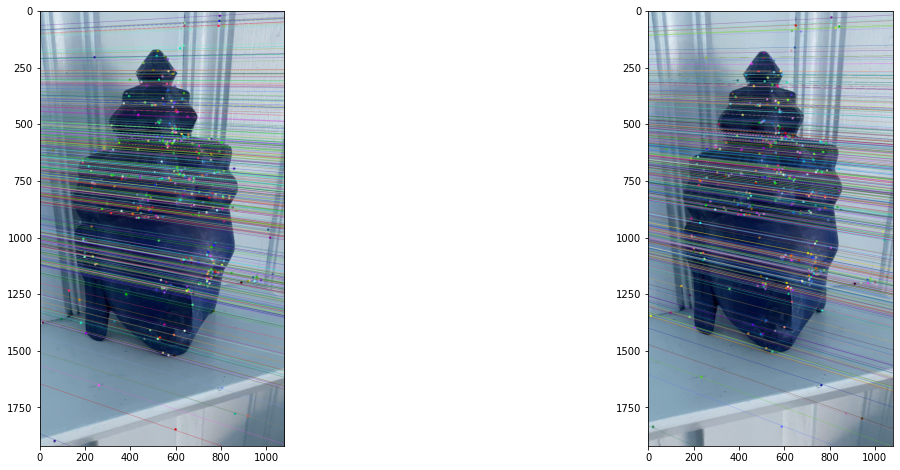

In [13]:
# Find epilines corresponding to points in right image (second image) and drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(imgs_norm[6],imgs_norm[7],lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(imgs_norm[7],imgs_norm[6],lines2,pts2,pts1)
plt.figure(figsize=(20,8))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

# Find 3D Points of the Buddha Statue

In [14]:
def get_essential_matrix(src_points, dest_points, camera_matrix):
    "Find essential matrix -- K'FK = E"
    essential_matrix, essential_mask = cv2.findEssentialMat(src_points, dest_points, camera_matrix, cv2.RANSAC, 0.999, 1.0)
    
    return essential_mask, essential_matrix

In [15]:
def get_cam_pose(src_points, dest_points, camera_matrix):
    "Find Camera Pose from essential matrix"
    essential_mask, essential_matrix = get_essential_matrix(dest_points, src_points, camera_matrix)
    
    essential_mask = np.squeeze(essential_mask != 0)

    index_mask = np.arange(len(src_points))

    index_mask = index_mask[essential_mask]
    dest_points = dest_points[essential_mask]
    src_points = src_points[essential_mask]

    _, rotation_matrix, translation, pose_mask = cv2.recoverPose(essential_matrix, dest_points, src_points, camera_matrix)
    
    return rotation_matrix, translation, index_mask[np.squeeze(pose_mask != 0)]

In [16]:
# get transformation matrix from rotation and translation matrices
def get_transformation_matrix(rotation_matrix, translation_matrix):
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :] = np.hstack((rotation_matrix, translation_matrix))
    return transformation_matrix

In [17]:
# Get projection matrix from transformation matrix and camera matrix
def get_projection_matrix(transformation_matrix, camera_matrix):
    return camera_matrix.dot(np.linalg.inv(transformation_matrix)[:3])

In [18]:
# Get 3D points of the buddha from the projection matrices and the src and dest keypoints
def get_buddha_points(src_projection_matrix, dest_projection_matrix, src_points, dest_points):
    
    buddha_points = cv2.triangulatePoints(src_projection_matrix, dest_projection_matrix, src_points.T, dest_points.T)

    return (buddha_points/buddha_points[-1])[:-1].T

In [19]:
def plot_camera(R,t,ax,scale=.5,depth=.5,faceColor='grey'):

    C = -t #camera center (in world coordinate system)

    #Generating camera coordinate axes
    axes = np.zeros((3,6))
    axes[0,1], axes[1,3],axes[2,5] = 1,1,1
    
    #Transforming to world coordinate system 
    axes = R.T.dot(axes)+C[:,np.newaxis]

    #Plotting axes
    ax.plot3D(xs=axes[0,:2],ys=axes[1,:2],zs=axes[2,:2],c='r')
    ax.plot3D(xs=axes[0,2:4],ys=axes[1,2:4],zs=axes[2,2:4],c='g')
    ax.plot3D(xs=axes[0,4:],ys=axes[1,4:],zs=axes[2,4:],c='b')

    #generating 5 corners of camera polygon 
    pt1 = np.array([[0,0,0]]).T #camera centre
    pt2 = np.array([[scale,-scale,depth]]).T #upper right 
    pt3 = np.array([[scale,scale,depth]]).T #lower right 
    pt4 = np.array([[-scale,-scale,depth]]).T #upper left
    pt5 = np.array([[-scale,scale,depth]]).T #lower left
    pts = np.concatenate((pt1,pt2,pt3,pt4,pt5),axis=-1)
    
    #Transforming to world-coordinate system
    pts = R.T.dot(pts)+C[:,np.newaxis]
    ax.scatter3D(xs=pts[0,:],ys=pts[1,:],zs=pts[2,:],c='k')
    
    #Generating a list of vertices to be connected in polygon
    verts = [[pts[:,0],pts[:,1],pts[:,2]], [pts[:,0],pts[:,2],pts[:,-1]],
            [pts[:,0],pts[:,-1],pts[:,-2]],[pts[:,0],pts[:,-2],pts[:,1]]]
    
    #Generating a polygon now..
    ax.add_collection3d(Poly3DCollection(verts, facecolors=faceColor,
                                         linewidths=1, edgecolors='k', alpha=.25))

In [20]:
rot_mat, trans_mat, index = get_cam_pose(pts1, pts2, cam_matrix)
print(rot_mat)
print(trans_mat)

[[ 0.9975723   0.02383749 -0.06543148]
 [-0.02406377  0.99970685 -0.00267213]
 [ 0.0653486   0.00424017  0.99785349]]
[[ 0.96391208]
 [ 0.13237109]
 [-0.23097919]]


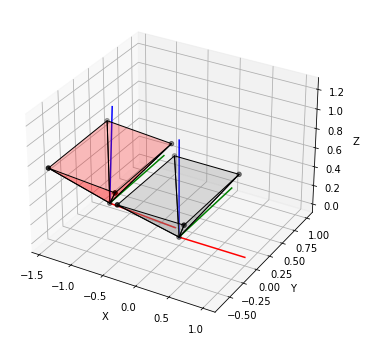

In [21]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plot_camera(np.eye(3,3),np.zeros((3,)),ax)
plot_camera(rot_mat, trans_mat[:,0],ax, faceColor='red')

In [22]:
rot_mat, trans_mat, index = get_cam_pose(pts1, pts2, cam_matrix)
pts1 = pts1[index]
pts2 = pts2[index]
transformation_matrix = get_transformation_matrix(rot_mat, trans_mat)
projection_matrix = get_projection_matrix(transformation_matrix, cam_matrix)

pts = get_buddha_points(cam_matrix.dot(np.hstack((np.eye(3), np.zeros((3, 1))))), projection_matrix, pts1, pts2)
print(pts)

In [23]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plot_camera(np.eye(3,3),np.zeros((3,)),ax)
plot_camera(rot_mat, trans_mat[:,0],ax, faceColor='red')
ax.scatter(pts[:][0],pts[:][1],pts[:][2])

plt.show()

In [24]:
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# plot_camera(np.eye(3,3),np.zeros((3,)),ax)

# for i in range(len(imgs_norm)-1):
#     pts1, pts2, _, _ = match_keypoints(keypoints_list[i], features_list[i], keypoints_list[i+1], features_list[i+1], clahe_imgs[i], clahe_imgs[i+1], show_result=False)
#     rot_mat, trans_mat, index = get_cam_pose(pts1, pts2, cam_matrix)
#     plot_camera(rot_mat, trans_mat[:,0],ax, faceColor='red')

# plt.show()

In [25]:
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# for i in range(len(imgs_norm)-1):
#     pts1, pts2, _,_ = match_keypoints(keypoints_list[i], features_list[i], keypoints_list[i+1], features_list[i+1], clahe_imgs[i], clahe_imgs[i+1], show_result=False)

#     rot_mat, trans_mat, index = get_cam_pose(pts1, pts2, cam_matrix)
#     pts1 = pts1[index]
#     pts2 = pts2[index]
#     transformation_matrix = get_transformation_matrix(rot_mat, trans_mat)
#     projection_matrix = get_projection_matrix(transformation_matrix, cam_matrix)

#     pts = get_buddha_points(cam_matrix.dot(np.hstack((np.eye(3), np.zeros((3, 1))))), projection_matrix, pts1, pts2)
#     ax.scatter(pts[:][0],pts[:][1],pts[:][2])

# plt.show()

In [26]:
# Check if determinant of rotation matrix is correct
print(np.linalg.det(rot_mat))

In [27]:
def plot_match_points(left_image, right_image, left_points, right_points):

    match_image = np.hstack((left_image, right_image))
    left_image_width = left_image.shape[1]
    for left_point, right_point in zip(left_points.astype(int), right_points.astype(int)):
        left_match_point = tuple(left_point)
        right_match_point = tuple(right_point + np.array([left_image_width, 0]))
        cv2.circle(match_image, left_match_point, 5, (0, 255, 0), -1)
        cv2.circle(match_image, right_match_point, 5, (0, 255, 0), -1)
        cv2.line(match_image, left_match_point, right_match_point, (0, 255, 0), 1)

    plt.imshow(match_image)
    plt.show()

# Use GTSAM to optimize

In [28]:
# Initialize gtsam nonlinear factor graph
symbol_X = gtsam.symbol_shorthand.X
symbol_L = gtsam.symbol_shorthand.L

gtsam_camera_matrix = gtsam.Cal3_S2(cam_matrix[0, 0], cam_matrix[1, 1], 0.0, cam_matrix[0, 2], cam_matrix[1, 2])

# One pixel noise in both u and v
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1.0)

# 0.3 rad std on roll, pitch, yaw and 0.1m std on x,y,z
pose_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.3, 0.1, 0.1, 0.1]))

# 0.1m std on x,y,z
point_noise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

graph = gtsam.NonlinearFactorGraph()

initial = gtsam.Values()

## Find the points for the first 2 images

In [29]:
transformation_matrices = []
projection_matrices = []

# Find points between first 2 images
pts1, pts2, pts1_index, pts2_index = match_keypoints(keypoints_list[0], features_list[0], keypoints_list[1], features_list[1], clahe_imgs[0], clahe_imgs[1], show_result=False)

rot_mat, trans_mat, index = get_cam_pose(pts1, pts2, cam_matrix)

pts1 = pts1[index]
pts2 = pts2[index]
pts1_index = pts1_index[index]
pts2_index = pts2_index[index]

transformation_matrix = get_transformation_matrix(rot_mat, trans_mat)
projection_matrix = get_projection_matrix(transformation_matrix, cam_matrix)

transformation_matrices.append(transformation_matrix)
projection_matrices.append(projection_matrix)


In [30]:
print(transformation_matrices[0])

[[ 0.99876874  0.01186913 -0.04816761  0.38363896]
 [-0.01202046  0.99992368 -0.00285325 -0.37346305]
 [ 0.04813007  0.00342874  0.99883519  0.84459842]
 [ 0.          0.          0.          1.        ]]


In [31]:
# Add a prior on the first camera pose. This specifies where the origin is
pose_factor = gtsam.PriorFactorPose3(symbol_X(0), gtsam.Pose3(), pose_noise)
graph.push_back(pose_factor)

# Insert the initial estimate
initial.insert(symbol_X(0), gtsam.Pose3())

initial.insert(symbol_X(1), gtsam.Pose3(gtsam.Rot3(rot_mat), gtsam.Point3(trans_mat.flatten())))

sum_all_buddha_points = list(get_buddha_points(cam_matrix.dot(np.hstack((np.eye(3), np.zeros((3, 1))))), projection_matrix, pts1, pts2))

prev_transformation_matrix = transformation_matrix.copy()
prev_projection_matrix = projection_matrix.copy()

point_factor = gtsam.PriorFactorPoint3(symbol_L(0), sum_all_buddha_points[0], point_noise)
graph.push_back(point_factor)

# Sum of each 3D object point color (bgr),
# divided by the count of them can get the average color of each point
sum_all_object_points_color = []
# Counter of each 3D object point
all_object_points_count = []

img_one_object_index_array = buddha_point_index_list[0]
img_two_object_index_array = buddha_point_index_list[1]
img_one_norm = bgr_imgs[0]
img_two_norm = bgr_imgs[1]

rint_src_points = np.rint(pts1).astype(int)
rint_dst_points = np.rint(pts2).astype(int)

for object_index, (src_point, dst_point, src_point_index, dst_point_index, object_point, rint_src_point, rint_dst_point) in enumerate(zip(pts1,
                                                                                                                                          pts2,
                                                                                                                                          pts1_index,
                                                                                                                                          pts2_index,
                                                                                                                                          sum_all_buddha_points,
                                                                                                                                          rint_src_points,
                                                                                                                                          rint_dst_points)):
    

    img_one_object_index_array[src_point_index] = object_index
    img_two_object_index_array[dst_point_index] = object_index
    
    # Each feature is measured by camera_0 and camera_1, add measurement factor into graph
    graph.push_back(gtsam.GenericProjectionFactorCal3_S2(src_point, measurement_noise, symbol_X(0), symbol_L(object_index), gtsam_camera_matrix))

    graph.push_back(gtsam.GenericProjectionFactorCal3_S2(dst_point, measurement_noise, symbol_X(1), symbol_L(object_index), gtsam_camera_matrix))
    
    # Cumulative the color of each point
    sum_all_object_points_color.append(img_one_norm[rint_src_point[1], rint_src_point[0]] + img_two_norm[rint_dst_point[1], rint_dst_point[0]])

    all_object_points_count.append(2)


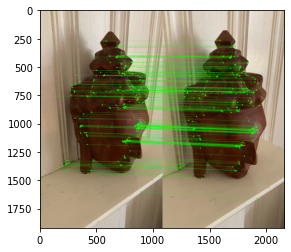

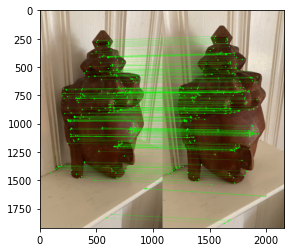

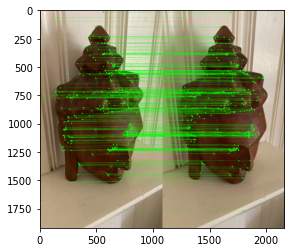

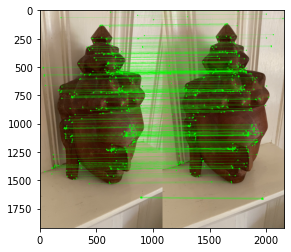

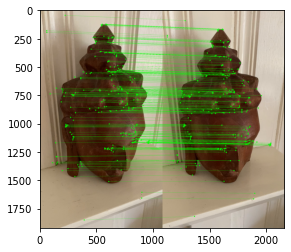

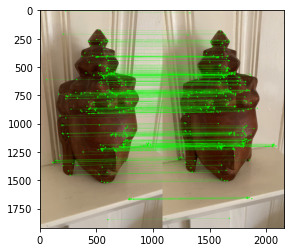

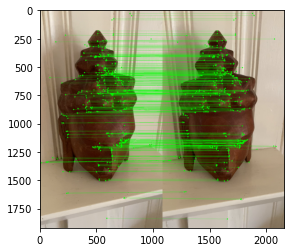

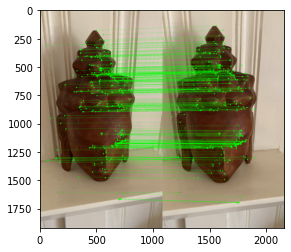

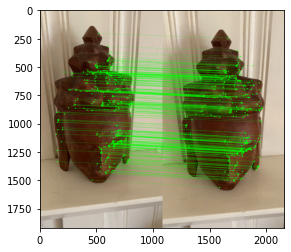

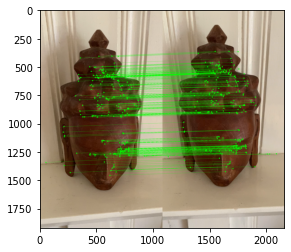

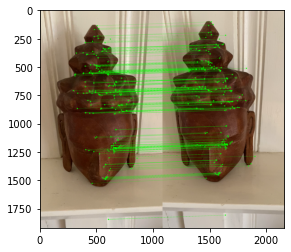

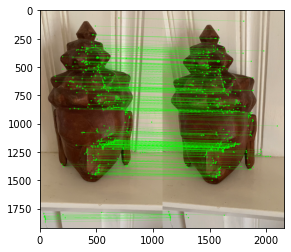

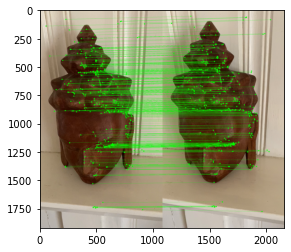

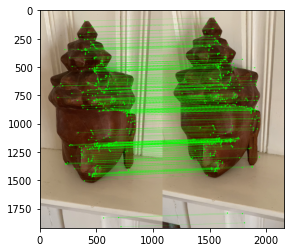

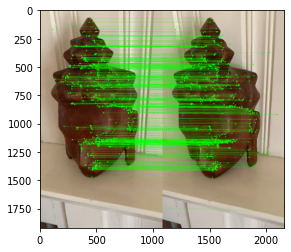

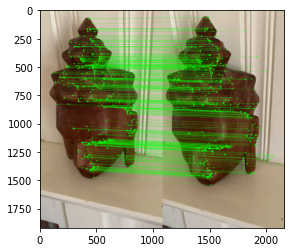

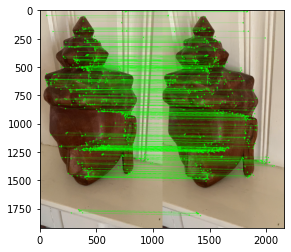

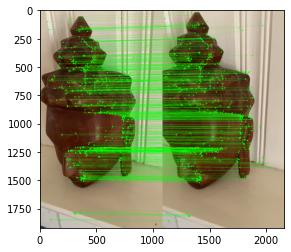

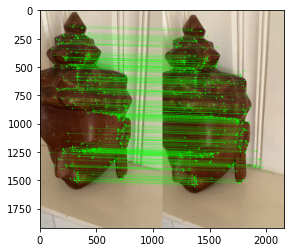

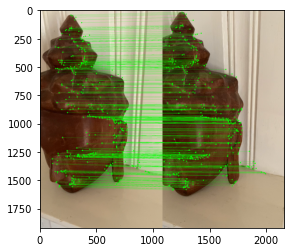

In [32]:
for i in range(1, len(imgs_norm)-1):
    
    pts1, pts2, pts1_index, pts2_index = match_keypoints(keypoints_list[i], features_list[i], keypoints_list[i+1], features_list[i+1], clahe_imgs[i], clahe_imgs[i+1], show_result=False)

    rot_mat, trans_mat, index = get_cam_pose(pts1, pts2, cam_matrix)
    
    pts1 = pts1[index]
    pts2 = pts2[index]
    pts1_index = pts1_index[index]
    pts2_index = pts2_index[index]

    plot_match_points(imgs_norm[i], imgs_norm[i+1], pts1, pts2)

    transformation_matrix = get_transformation_matrix(rot_mat, trans_mat).dot(prev_transformation_matrix)
    projection_matrix = get_projection_matrix(transformation_matrix, cam_matrix)

    img_one_object_index_array = buddha_point_index_list[i]
    img_two_object_index_array = buddha_point_index_list[i+1]

    img_one_norm = bgr_imgs[i]
    img_two_norm = bgr_imgs[i+1]

    match_img_one_points = []
    match_img_two_points = []
    match_buddha_points = []

    # Find all matching points that exist as 3D points before
    for src_point, dst_point, src_point_index in zip(pts1, pts2, pts1_index):

        object_index = img_one_object_index_array[src_point_index]
        if object_index != -1:
            match_img_one_points.append(src_point)
            match_img_two_points.append(dst_point)
            match_buddha_points.append(
                sum_all_buddha_points[object_index]/(all_object_points_count[object_index]-1))

    match_img_one_points = np.array(match_img_one_points)
    match_img_two_points = np.array(match_img_two_points)
    match_buddha_points = np.array(match_buddha_points)

    # Use these existing 3D points to find the correct scale
    buddha_points = get_buddha_points(prev_projection_matrix, projection_matrix, match_img_one_points, match_img_two_points)

    scale = 0
    for match_object_point, object_point in zip(match_buddha_points, buddha_points):
        scale += cv2.norm(match_object_point)/cv2.norm(object_point)

    scale /= len(buddha_points)

    trans_mat *= scale

    # New transformation matrix with scale
    transformation_matrix = get_transformation_matrix(rot_mat, trans_mat).dot(prev_transformation_matrix)

    initial.insert(symbol_X(i+1), gtsam.Pose3(gtsam.Rot3(transformation_matrix[:3, :3]), gtsam.Point3(transformation_matrix[:3, 3])))

    projection_matrix = get_projection_matrix(transformation_matrix, cam_matrix)

    buddha_points = get_buddha_points(prev_projection_matrix, projection_matrix, pts1, pts2)

    # transformation_matrices.append(transformation_matrix)
    # projection_matrices.append(projection_matrix)

    prev_transformation_matrix = transformation_matrix.copy()
    prev_projection_matrix = projection_matrix.copy()

    rint_src_points = np.rint(pts1).astype(int)
    rint_dst_points = np.rint(pts2).astype(int)

    current_object_index = len(all_object_points_count)

    for src_point, dst_point, src_point_index, dst_point_index, object_point, rint_src_point, rint_dst_point in zip(pts1,
                                                                                                                    pts2,
                                                                                                                    pts1_index,
                                                                                                                    pts2_index,
                                                                                                                    buddha_points,
                                                                                                                    rint_src_points,
                                                                                                                    rint_dst_points):
        object_index = img_one_object_index_array[src_point_index]

        # If the 3D point is newly detected, it has never appeared before
        if object_index == -1:

            object_index = current_object_index
            
            # Add new point to 3D point list
            sum_all_buddha_points.append(object_point)
            
            # Add new point to point color list
            sum_all_object_points_color.append(img_one_norm[rint_src_point[1], rint_src_point[0]] + img_two_norm[rint_dst_point[1], rint_dst_point[0]])

            all_object_points_count.append(2)

            img_one_object_index_array[src_point_index] = img_two_object_index_array[
                dst_point_index] = object_index

            current_object_index += 1
        # Else, the 3D point exists, find it by index
        else:
            img_two_object_index_array[dst_point_index] = object_index
            
            # Cumulative the color of each 3D point
            sum_all_buddha_points[object_index] += object_point
            sum_all_object_points_color[object_index] += img_two_norm[rint_dst_point[1],
                                                                       rint_dst_point[0]]
            
            # Counter ++
            all_object_points_count[object_index] += 1
        
        # Each feature is measured by both src_camera and dst_camera, add measurement factor into graph
        graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
            src_point, measurement_noise, symbol_X(i), symbol_L(object_index), gtsam_camera_matrix))

        graph.push_back(gtsam.GenericProjectionFactorCal3_S2(
            dst_point, measurement_noise, symbol_X(i+1), symbol_L(object_index), gtsam_camera_matrix))


In [33]:
# Run global optimization on gtsam nonlinear factor graph
all_object_points_count = np.array(
    [all_object_points_count, all_object_points_count, all_object_points_count]).T

# Calculate the average color of each 3D point
all_object_points = np.array(sum_all_buddha_points)/(all_object_points_count-1)
all_object_points_color = np.flip(np.array(sum_all_object_points_color)/all_object_points_count).astype(np.uint8)

for object_index, object_point in enumerate(all_object_points):
    initial.insert(symbol_L(object_index), gtsam.Point3(object_point))

params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()

/var/folders/1c/6chd8t_90dbbd8qqhm8brg600000gn/T/ipykernel_8713/1930689308.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gtsam/utils/plot.py:324: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axes

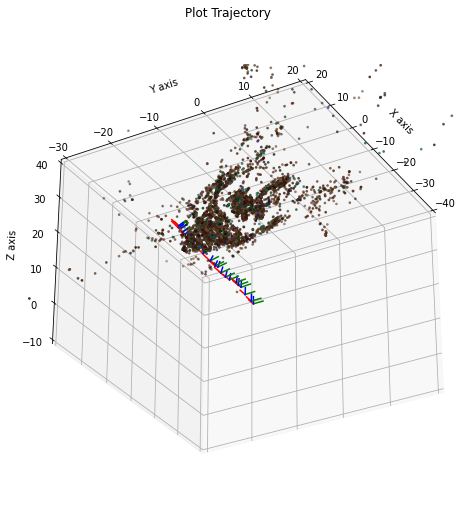

In [49]:
%matplotlib inline

fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')

final_object_points = []
for index in range(len(all_object_points)):
    final_object_points.append(result.atPoint3(symbol_L(index)))

final_object_points = np.array(final_object_points)

ax.scatter(final_object_points[:, 0],
           final_object_points[:, 1], final_object_points[:, 2], c=all_object_points_color/255., s=3)

# gtsam.utils.plot.plot_3d_points(1, result)
gtsam.utils.plot.plot_trajectory(1, result, scale=2)
gtsam.utils.plot.set_axes_equal(1)

ax.set_xlim3d(-40, 20)
ax.set_ylim3d(-30, 20)
ax.set_zlim3d(-10, 40)

ax.view_init(-30, 30)

plt.show()